# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

2022-10-07 16:29:58.850895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 16:29:58.850980: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop

In [7]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [8]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

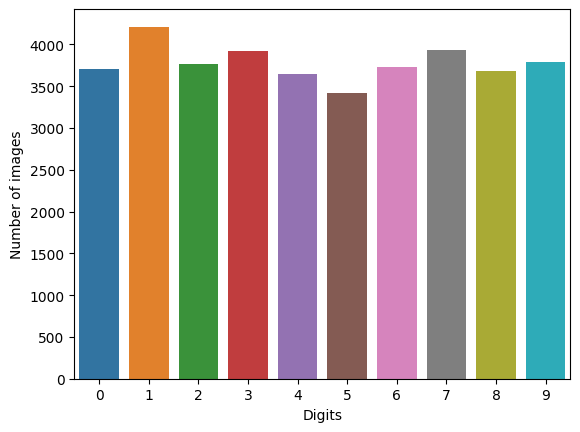

In [10]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [11]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [12]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [13]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1])

In [14]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

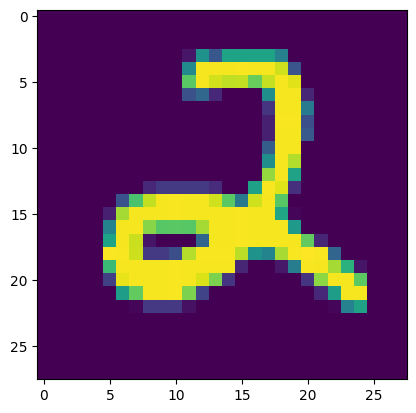

In [15]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

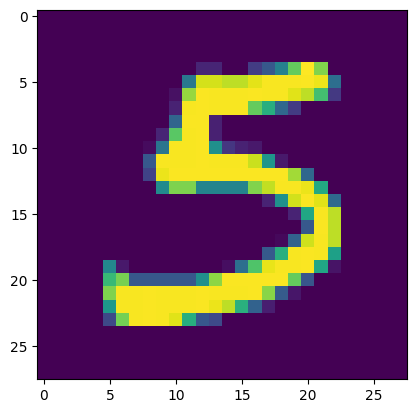

In [16]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [17]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [18]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical.
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [19]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [20]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2022-10-07 16:32:08,517] Using an existing study with name 'cnn_study' instead of creating a new one.
2022-10-07 16:32:08.571401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-07 16:32:08.571489: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-07 16:32:08.571547: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAP-VK-DS): /proc/driver/nvidia/version does not exist
2022-10-07 16:32:08.572815: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ku

Epoch 1/3
266/266 [==============================] - 9s 33ms/step - loss: 0.2153 - accuracy: 0.9308 - val_loss: 0.1051 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 9s 33ms/step - loss: 0.0645 - accuracy: 0.9796 - val_loss: 0.1329 - val_accuracy: 0.9664
Epoch 3/3
266/266 [==============================] - 11s 41ms/step - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.0703 - val_accuracy: 0.9775


[I 2022-10-07 16:32:37,516] Trial 30 finished with value: 0.9775132536888123 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 257, 'optimizer_name': 'Adam', 'learning_rate': 0.0028749964721622202}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 3s 12ms/step - loss: 0.2479 - accuracy: 0.9240 - val_loss: 0.0994 - val_accuracy: 0.9717
Epoch 2/3
266/266 [==============================] - 3s 10ms/step - loss: 0.0685 - accuracy: 0.9788 - val_loss: 0.0749 - val_accuracy: 0.9786
Epoch 3/3
266/266 [==============================] - 3s 10ms/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 0.0751 - val_accuracy: 0.9783


[I 2022-10-07 16:32:46,452] Trial 31 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 134, 'optimizer_name': 'Adam', 'learning_rate': 0.0022859969591482727}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 3s 12ms/step - loss: 0.2423 - accuracy: 0.9254 - val_loss: 0.0927 - val_accuracy: 0.9757
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0656 - accuracy: 0.9800 - val_loss: 0.0801 - val_accuracy: 0.9775
Epoch 3/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0406 - accuracy: 0.9868 - val_loss: 0.0569 - val_accuracy: 0.9810


[I 2022-10-07 16:32:58,197] Trial 32 finished with value: 0.9809523820877075 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 199, 'optimizer_name': 'Adam', 'learning_rate': 0.001584638220804333}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 3s 9ms/step - loss: 0.3032 - accuracy: 0.9058 - val_loss: 0.1173 - val_accuracy: 0.9653
Epoch 2/3
266/266 [==============================] - 2s 9ms/step - loss: 0.0827 - accuracy: 0.9748 - val_loss: 0.0830 - val_accuracy: 0.9762
Epoch 3/3
266/266 [==============================] - 2s 9ms/step - loss: 0.0516 - accuracy: 0.9832 - val_loss: 0.0726 - val_accuracy: 0.9802


[I 2022-10-07 16:33:05,791] Trial 33 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 52, 'optimizer_name': 'Adam', 'learning_rate': 0.0019681839611223606}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 3s 12ms/step - loss: 0.3185 - accuracy: 0.9024 - val_loss: 0.1224 - val_accuracy: 0.9632
Epoch 2/3
266/266 [==============================] - 3s 12ms/step - loss: 0.0850 - accuracy: 0.9734 - val_loss: 0.0803 - val_accuracy: 0.9780
Epoch 3/3
266/266 [==============================] - 3s 13ms/step - loss: 0.0548 - accuracy: 0.9824 - val_loss: 0.0723 - val_accuracy: 0.9783


[I 2022-10-07 16:33:16,123] Trial 34 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 155, 'optimizer_name': 'Adam', 'learning_rate': 0.001046008023511306}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2739 - accuracy: 0.9145 - val_loss: 0.1108 - val_accuracy: 0.9675
Epoch 2/3
266/266 [==============================] - 2s 7ms/step - loss: 0.0728 - accuracy: 0.9780 - val_loss: 0.0875 - val_accuracy: 0.9762
Epoch 3/3
266/266 [==============================] - 2s 7ms/step - loss: 0.0494 - accuracy: 0.9848 - val_loss: 0.0726 - val_accuracy: 0.9788


[I 2022-10-07 16:33:22,171] Trial 35 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 121, 'optimizer_name': 'Adam', 'learning_rate': 0.0021631028237980316}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 13s 47ms/step - loss: 0.4537 - accuracy: 0.8738 - val_loss: 0.1761 - val_accuracy: 0.9516
Epoch 2/3
266/266 [==============================] - 13s 49ms/step - loss: 0.1672 - accuracy: 0.9475 - val_loss: 0.2144 - val_accuracy: 0.9405
Epoch 3/3
266/266 [==============================] - 13s 49ms/step - loss: 0.1393 - accuracy: 0.9574 - val_loss: 0.1528 - val_accuracy: 0.9585


[I 2022-10-07 16:34:01,328] Trial 36 finished with value: 0.9584656357765198 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 238, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0030938870093104856, 'momentum': 0.617294947713203}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 4s 14ms/step - loss: 0.2399 - accuracy: 0.9240 - val_loss: 0.1018 - val_accuracy: 0.9701
Epoch 2/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0734 - accuracy: 0.9785 - val_loss: 0.0863 - val_accuracy: 0.9780
Epoch 3/3
266/266 [==============================] - 4s 13ms/step - loss: 0.0544 - accuracy: 0.9833 - val_loss: 0.0862 - val_accuracy: 0.9791


[I 2022-10-07 16:34:12,610] Trial 37 finished with value: 0.9791005253791809 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 273, 'optimizer_name': 'Adam', 'learning_rate': 0.009939438393992705}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 3s 11ms/step - loss: 0.2247 - accuracy: 0.9291 - val_loss: 0.1053 - val_accuracy: 0.9701
Epoch 2/3
266/266 [==============================] - 3s 10ms/step - loss: 0.0824 - accuracy: 0.9762 - val_loss: 0.1348 - val_accuracy: 0.9677
Epoch 3/3
266/266 [==============================] - 3s 11ms/step - loss: 0.0638 - accuracy: 0.9813 - val_loss: 0.1169 - val_accuracy: 0.9667


[I 2022-10-07 16:34:21,480] Trial 38 finished with value: 0.9666666388511658 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 350, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003840317644282336, 'momentum': 0.6124454353609168}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 3s 12ms/step - loss: 2.2514 - accuracy: 0.2320 - val_loss: 2.1532 - val_accuracy: 0.4304
Epoch 2/3
266/266 [==============================] - 3s 11ms/step - loss: 2.0416 - accuracy: 0.5395 - val_loss: 1.9150 - val_accuracy: 0.5995
Epoch 3/3
266/266 [==============================] - 3s 12ms/step - loss: 1.7671 - accuracy: 0.6327 - val_loss: 1.6163 - val_accuracy: 0.6601


[I 2022-10-07 16:34:31,259] Trial 39 finished with value: 0.6600528955459595 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 181, 'optimizer_name': 'Adam', 'learning_rate': 9.908405948296558e-06}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 138s 519ms/step - loss: 1.1750 - accuracy: 0.5852 - val_loss: 0.7998 - val_accuracy: 0.7497
Epoch 2/3
266/266 [==============================] - 134s 505ms/step - loss: 0.5984 - accuracy: 0.8238 - val_loss: 0.4887 - val_accuracy: 0.8611
Epoch 3/3
266/266 [==============================] - 140s 525ms/step - loss: 0.3904 - accuracy: 0.8859 - val_loss: 0.3211 - val_accuracy: 0.9378


[I 2022-10-07 16:41:23,954] Trial 40 finished with value: 0.9378306865692139 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 5, 'optimizer_name': 'Adam', 'learning_rate': 0.0016026768417814273}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 5s 18ms/step - loss: 0.2484 - accuracy: 0.9229 - val_loss: 0.0908 - val_accuracy: 0.9741
Epoch 2/3
266/266 [==============================] - 4s 17ms/step - loss: 0.0641 - accuracy: 0.9805 - val_loss: 0.0705 - val_accuracy: 0.9794
Epoch 3/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0402 - accuracy: 0.9865 - val_loss: 0.0571 - val_accuracy: 0.9828


[I 2022-10-07 16:41:38,165] Trial 41 finished with value: 0.9828042387962341 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 237, 'optimizer_name': 'Adam', 'learning_rate': 0.00147076283876527}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 5s 16ms/step - loss: 0.3992 - accuracy: 0.8844 - val_loss: 0.1607 - val_accuracy: 0.9542
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.1072 - accuracy: 0.9679 - val_loss: 0.0953 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0677 - accuracy: 0.9795 - val_loss: 0.0739 - val_accuracy: 0.9786


[I 2022-10-07 16:41:51,589] Trial 42 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 232, 'optimizer_name': 'Adam', 'learning_rate': 0.0005175700019595675}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 4s 14ms/step - loss: 0.3133 - accuracy: 0.9043 - val_loss: 0.1060 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0791 - accuracy: 0.9756 - val_loss: 0.0849 - val_accuracy: 0.9735
Epoch 3/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0506 - accuracy: 0.9842 - val_loss: 0.0640 - val_accuracy: 0.9810


[I 2022-10-07 16:42:03,106] Trial 43 finished with value: 0.9809523820877075 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 157, 'optimizer_name': 'Adam', 'learning_rate': 0.0011793584827987933}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 4s 15ms/step - loss: 0.2204 - accuracy: 0.9316 - val_loss: 0.0861 - val_accuracy: 0.9775
Epoch 2/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0610 - accuracy: 0.9806 - val_loss: 0.0854 - val_accuracy: 0.9738
Epoch 3/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0359 - accuracy: 0.9886 - val_loss: 0.0646 - val_accuracy: 0.9796


[I 2022-10-07 16:42:15,141] Trial 44 finished with value: 0.979629635810852 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 199, 'optimizer_name': 'Adam', 'learning_rate': 0.002425426903282342}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 5s 18ms/step - loss: 0.3763 - accuracy: 0.8839 - val_loss: 0.1734 - val_accuracy: 0.9542
Epoch 2/3
266/266 [==============================] - 5s 18ms/step - loss: 0.0945 - accuracy: 0.9724 - val_loss: 0.1140 - val_accuracy: 0.9693
Epoch 3/3
266/266 [==============================] - 5s 18ms/step - loss: 0.0680 - accuracy: 0.9799 - val_loss: 0.1018 - val_accuracy: 0.9765


[I 2022-10-07 16:42:29,848] Trial 45 finished with value: 0.97645503282547 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 337, 'optimizer_name': 'RMSprop', 'learning_rate': 0.008232690129492373, 'momentum': 0.12874100955626838}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 6s 23ms/step - loss: 0.4976 - accuracy: 0.8530 - val_loss: 0.1921 - val_accuracy: 0.9423
Epoch 2/3
266/266 [==============================] - 6s 22ms/step - loss: 0.1419 - accuracy: 0.9562 - val_loss: 0.1337 - val_accuracy: 0.9603
Epoch 3/3
266/266 [==============================] - 6s 21ms/step - loss: 0.0947 - accuracy: 0.9708 - val_loss: 0.1221 - val_accuracy: 0.9656


[I 2022-10-07 16:42:47,959] Trial 46 finished with value: 0.9656084775924683 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 110, 'optimizer_name': 'Adam', 'learning_rate': 0.0006110464307694124}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 5s 17ms/step - loss: 0.2384 - accuracy: 0.9257 - val_loss: 0.0924 - val_accuracy: 0.9722
Epoch 2/3
266/266 [==============================] - 4s 17ms/step - loss: 0.0611 - accuracy: 0.9809 - val_loss: 0.0695 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 5s 18ms/step - loss: 0.0375 - accuracy: 0.9876 - val_loss: 0.0592 - val_accuracy: 0.9836


[I 2022-10-07 16:43:02,314] Trial 47 finished with value: 0.9835978746414185 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 285, 'optimizer_name': 'Adam', 'learning_rate': 0.0015556546500336747}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 7s 26ms/step - loss: 0.2137 - accuracy: 0.9341 - val_loss: 0.1086 - val_accuracy: 0.9672
Epoch 2/3
266/266 [==============================] - 7s 25ms/step - loss: 0.0732 - accuracy: 0.9765 - val_loss: 0.1024 - val_accuracy: 0.9706
Epoch 3/3
266/266 [==============================] - 8s 29ms/step - loss: 0.0508 - accuracy: 0.9839 - val_loss: 0.0837 - val_accuracy: 0.9754


[I 2022-10-07 16:43:25,054] Trial 48 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 283, 'optimizer_name': 'Adam', 'learning_rate': 0.001355294894328307}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 24s 79ms/step - loss: 0.2284 - accuracy: 0.9263 - val_loss: 0.0966 - val_accuracy: 0.9717
Epoch 2/3
266/266 [==============================] - 3s 11ms/step - loss: 0.0757 - accuracy: 0.9762 - val_loss: 0.0819 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 3s 10ms/step - loss: 0.0476 - accuracy: 0.9846 - val_loss: 0.0782 - val_accuracy: 0.9780


[I 2022-10-07 16:44:02,850] Trial 49 finished with value: 0.9780423045158386 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 416, 'optimizer_name': 'Adam', 'learning_rate': 0.0031886618054231893}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 6s 23ms/step - loss: 0.1929 - accuracy: 0.9373 - val_loss: 0.0978 - val_accuracy: 0.9704
Epoch 2/3
266/266 [==============================] - 6s 24ms/step - loss: 0.0676 - accuracy: 0.9796 - val_loss: 0.0790 - val_accuracy: 0.9778
Epoch 3/3
266/266 [==============================] - 6s 24ms/step - loss: 0.0453 - accuracy: 0.9865 - val_loss: 0.0723 - val_accuracy: 0.9791


[I 2022-10-07 16:44:23,149] Trial 50 finished with value: 0.9791005253791809 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 387, 'optimizer_name': 'Adam', 'learning_rate': 0.004228461199504465}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 6s 20ms/step - loss: 0.2117 - accuracy: 0.9324 - val_loss: 0.0804 - val_accuracy: 0.9751
Epoch 2/3
266/266 [==============================] - 5s 20ms/step - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.0751 - val_accuracy: 0.9786
Epoch 3/3
266/266 [==============================] - 5s 18ms/step - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.0586 - val_accuracy: 0.9823


[I 2022-10-07 16:44:39,794] Trial 51 finished with value: 0.982275128364563 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 321, 'optimizer_name': 'Adam', 'learning_rate': 0.001884633735732479}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 8s 24ms/step - loss: 0.1788 - accuracy: 0.9432 - val_loss: 0.0804 - val_accuracy: 0.9759
Epoch 2/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0531 - accuracy: 0.9837 - val_loss: 0.0731 - val_accuracy: 0.9815
Epoch 3/3
266/266 [==============================] - 6s 23ms/step - loss: 0.0346 - accuracy: 0.9883 - val_loss: 0.0570 - val_accuracy: 0.9841


[I 2022-10-07 16:45:00,565] Trial 52 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 507, 'optimizer_name': 'Adam', 'learning_rate': 0.0025820214359712837}. Best is trial 52 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 5s 16ms/step - loss: 0.2178 - accuracy: 0.9317 - val_loss: 0.0912 - val_accuracy: 0.9730
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0617 - accuracy: 0.9807 - val_loss: 0.0785 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0389 - accuracy: 0.9876 - val_loss: 0.0552 - val_accuracy: 0.9839


[I 2022-10-07 16:45:13,816] Trial 53 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 228, 'optimizer_name': 'Adam', 'learning_rate': 0.00259252545902319}. Best is trial 52 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 6s 22ms/step - loss: 0.1907 - accuracy: 0.9392 - val_loss: 0.0872 - val_accuracy: 0.9751
Epoch 2/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0540 - accuracy: 0.9829 - val_loss: 0.0772 - val_accuracy: 0.9791
Epoch 3/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0342 - accuracy: 0.9891 - val_loss: 0.0596 - val_accuracy: 0.9825


[I 2022-10-07 16:45:32,026] Trial 54 finished with value: 0.9825396537780762 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 502, 'optimizer_name': 'Adam', 'learning_rate': 0.00277901013753445}. Best is trial 52 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 6s 23ms/step - loss: 0.1916 - accuracy: 0.9384 - val_loss: 0.0813 - val_accuracy: 0.9767
Epoch 2/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0523 - accuracy: 0.9830 - val_loss: 0.0722 - val_accuracy: 0.9783
Epoch 3/3
266/266 [==============================] - 6s 22ms/step - loss: 0.0330 - accuracy: 0.9891 - val_loss: 0.0692 - val_accuracy: 0.9820


[I 2022-10-07 16:45:50,194] Trial 55 finished with value: 0.9820106029510498 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 494, 'optimizer_name': 'Adam', 'learning_rate': 0.0025539568952152613}. Best is trial 52 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 4s 16ms/step - loss: 0.1944 - accuracy: 0.9384 - val_loss: 0.0847 - val_accuracy: 0.9746
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0569 - accuracy: 0.9820 - val_loss: 0.0845 - val_accuracy: 0.9741
Epoch 3/3
266/266 [==============================] - 4s 15ms/step - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.0652 - val_accuracy: 0.9812


[I 2022-10-07 16:46:03,107] Trial 56 finished with value: 0.9812169075012207 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 225, 'optimizer_name': 'Adam', 'learning_rate': 0.00315395353855425}. Best is trial 52 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 4s 14ms/step - loss: 0.1961 - accuracy: 0.9370 - val_loss: 0.0872 - val_accuracy: 0.9759
Epoch 2/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.0689 - val_accuracy: 0.9794
Epoch 3/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 0.0641 - val_accuracy: 0.9807


[I 2022-10-07 16:46:14,948] Trial 57 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 170, 'optimizer_name': 'Adam', 'learning_rate': 0.003930463057382824}. Best is trial 52 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 143s 537ms/step - loss: 0.1639 - accuracy: 0.9479 - val_loss: 0.0625 - val_accuracy: 0.9823
Epoch 2/3
266/266 [==============================] - 140s 526ms/step - loss: 0.0445 - accuracy: 0.9857 - val_loss: 0.0648 - val_accuracy: 0.9841
Epoch 3/3
266/266 [==============================] - 135s 507ms/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0607 - val_accuracy: 0.9862


[I 2022-10-07 16:53:13,318] Trial 58 finished with value: 0.9862433671951294 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 464, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007228774553249635, 'momentum': 0.6901026083118498}. Best is trial 58 with value: 0.9862433671951294.


Epoch 1/3
266/266 [==============================] - 136s 510ms/step - loss: 0.1611 - accuracy: 0.9503 - val_loss: 0.0619 - val_accuracy: 0.9802
Epoch 2/3
266/266 [==============================] - 137s 515ms/step - loss: 0.0439 - accuracy: 0.9859 - val_loss: 0.0678 - val_accuracy: 0.9833
Epoch 3/3
266/266 [==============================] - 138s 518ms/step - loss: 0.0292 - accuracy: 0.9911 - val_loss: 0.0491 - val_accuracy: 0.9870


[I 2022-10-07 17:00:04,401] Trial 59 finished with value: 0.9870370626449585 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 472, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008511918040171204, 'momentum': 0.6944741864418609}. Best is trial 59 with value: 0.9870370626449585.


# Analyze results

In [21]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 5,
 'learning_rate': 0.0008511918040171204,
 'momentum': 0.6944741864418609,
 'num_conv_layers': 2,
 'num_dense_layers': 1,
 'optimizer_name': 'RMSprop',
 'strides': 1,
 'units': 472}

In [22]:
study.best_value

0.9870370626449585

Text(0, 0.5, 'Accuracy')

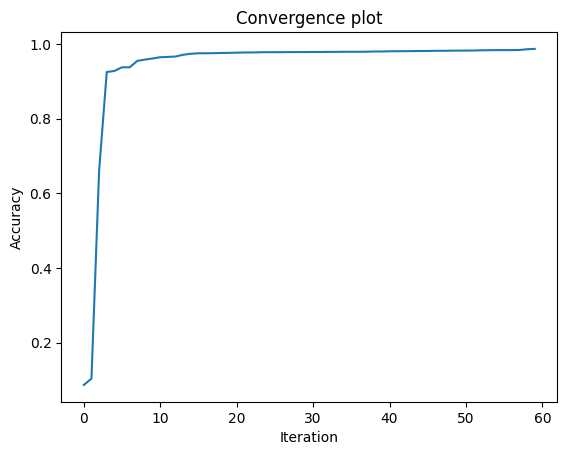

In [23]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Evaluate the model

In [24]:
# load best model

model = load_model(path_best_model)

In [25]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_87 (Dense)             (None, 472)               5921240   
_________________________________________________________________
dense_88 (Dense)             (None, 10)                4730      
Total params: 6,030,098
Trainable params: 6,030,098
Non-trainable params: 0
___________________________________________

In [26]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 3s 19ms/step - loss: 0.0378 - accuracy: 0.9879


In [27]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.03779510781168938
accuracy 0.9878571629524231


## Confusion matrix

In [28]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[418,   0,   0,   0,   0,   0,   1,   0,   2,   1],
       [  0, 470,   0,   0,   0,   0,   1,   1,   1,   0],
       [  0,   1, 405,   0,   0,   0,   1,   0,   2,   0],
       [  0,   0,   1, 420,   0,   3,   0,   2,   0,   0],
       [  1,   1,   0,   0, 423,   0,   2,   1,   0,   1],
       [  0,   0,   0,   1,   0, 377,   2,   1,   1,   0],
       [  0,   0,   0,   0,   2,   0, 409,   0,   0,   1],
       [  0,   3,   3,   0,   0,   1,   0, 462,   0,   0],
       [  0,   1,   1,   0,   0,   0,   2,   0, 380,   0],
       [  1,   1,   0,   0,   6,   0,   0,   0,   1, 385]])

Text(0.5, 21.34715460257995, 'Predicted label')

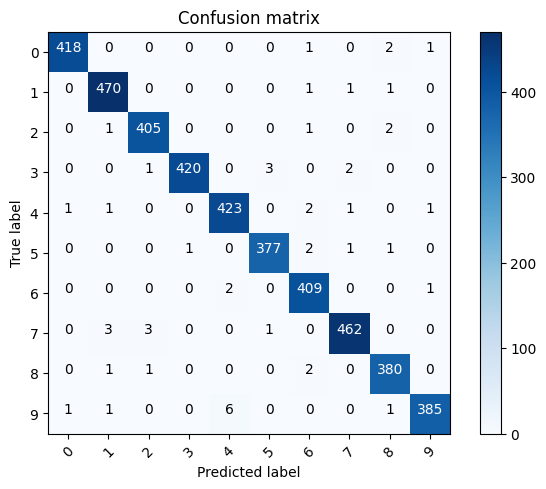

In [29]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.